In [1]:
!pip install pillow matplotlib

In [18]:
!pip install ace_tools

ERROR: Could not find a version that satisfies the requirement ace_tools (from versions: none)
ERROR: No matching distribution found for ace_tools


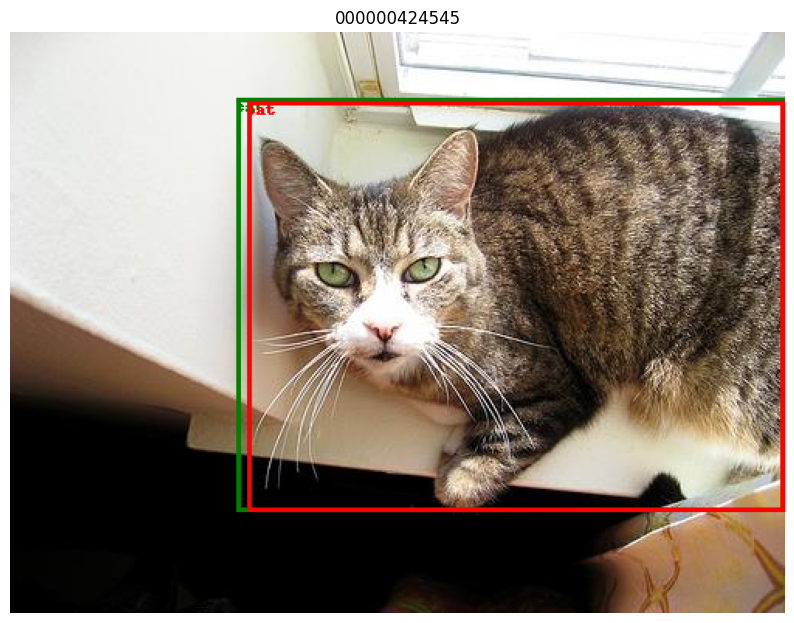

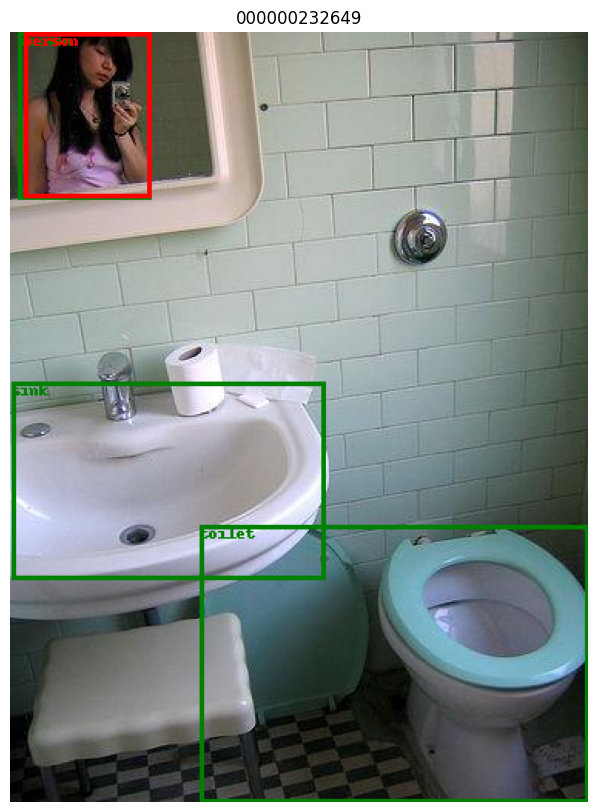

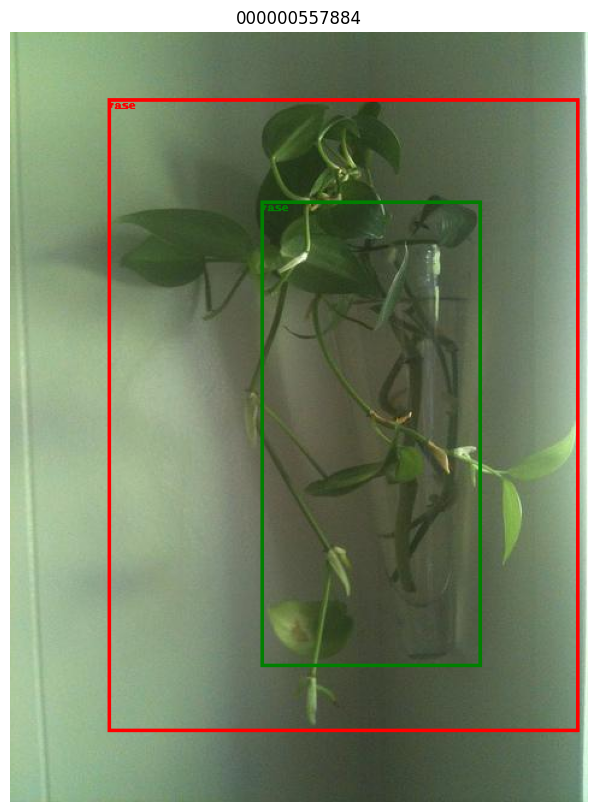

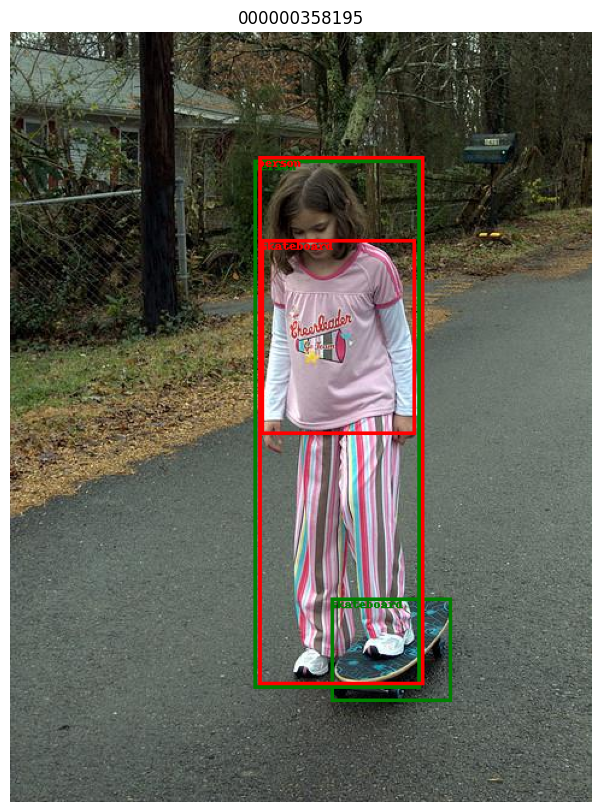

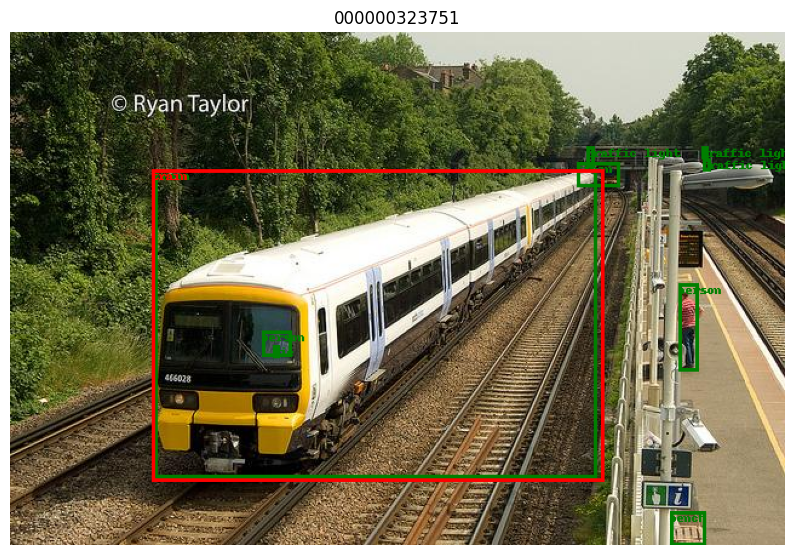

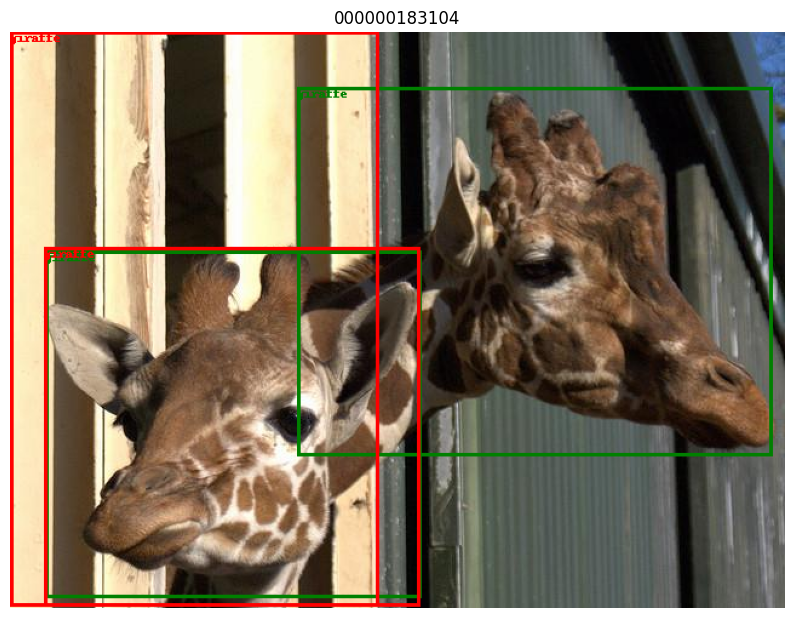

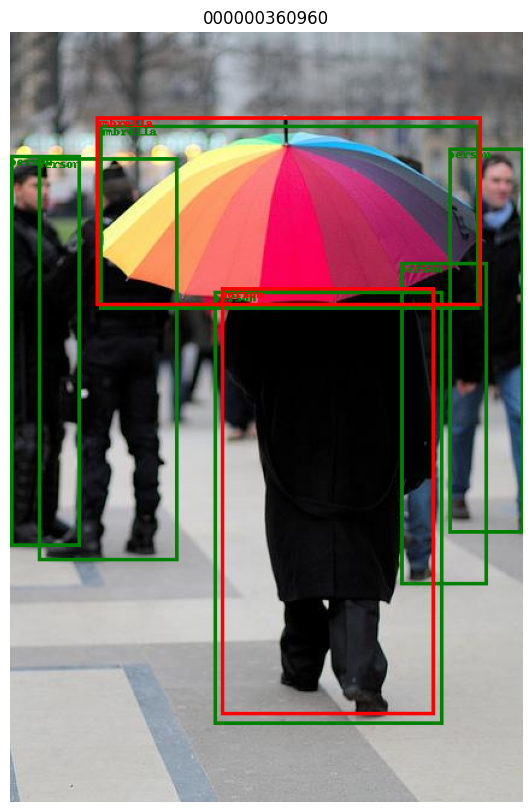

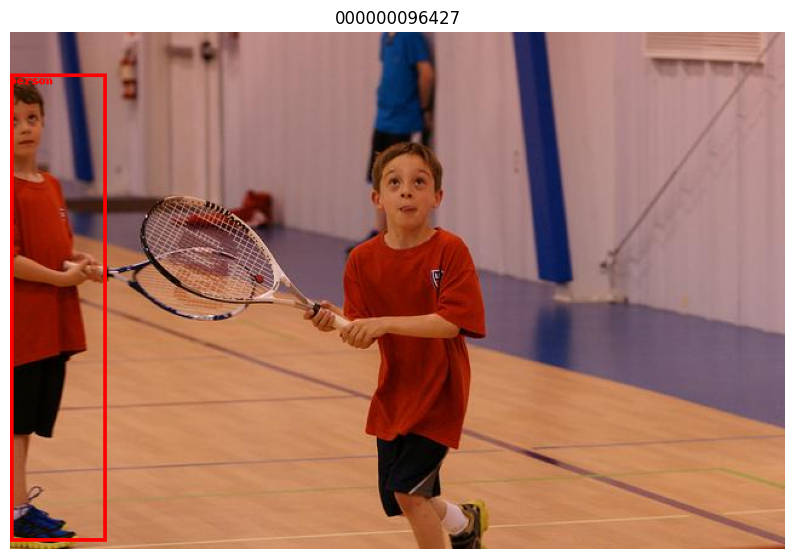

Image ID      Object       IoU
0   000000424545         cat  0.973944
1   000000232649      person  0.932568
2   000000557884        vase  0.343889
3   000000358195      person  0.937131
4   000000358195  skateboard  0.000000
5   000000323751       train  0.964825
6   000000323751       train  0.003204
7   000000183104     giraffe  0.957520
8   000000183104     giraffe  0.508073
9   000000183104     giraffe  0.089924
10  000000183104     giraffe  0.084227
11  000000360960    umbrella  0.926667
12  000000360960      person  0.907814
13  000000360960      person  0.000000
14  000000360960      person  0.000000
15  000000360960      person  0.000000
16  000000360960      person  0.093724

        Image ID      Object       IoU
0   000000424545         cat  0.973944
1   000000232649      person  0.932568
2   000000557884        vase  0.343889
3   000000358195      person  0.937131
4   000000358195  skateboard  0.000000
5   000000323751       train  0.964825
6   000000323751       train  0.003204
7   000000183104     giraffe  0.957520
8   000000183104     giraffe  0.508073
9   000000183104     giraffe  0.089924
10  000000183104     giraffe  0.084227
11  000000360960    umbrella  0.926667
12  000000360960      person  0.907814
13  000000360960      person  0.000000
14  000000360960      person  0.000000
15  000000360960      person  0.000000
16  000000360960      person  0.093724


In [23]:
import json
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

# Load the JSON data
with open('bbxes_objects.json', 'r') as file:
    predicted_bboxes = json.load(file)

with open('gt_bboxes.json', 'r') as file:
    ground_truth_bboxes = json.load(file)

# Define the list of images to process
image_ids = ["000000424545", "000000232649", "000000557884", "000000358195", "000000323751", "000000183104", "000000360960", "000000096427"]

# Function to adjust bounding boxes according to actual image dimensions
def adjust_bboxes(bboxes, orig_size, target_size=(1000, 1000)):
    orig_width, orig_height = orig_size
    adjusted_bboxes = []
    for bbox, label in bboxes:
        x, y, w, h = bbox
        # Scale the bounding box coordinates
        x = x / target_size[0] * orig_width
        y = y / target_size[1] * orig_height
        w = w / target_size[0] * orig_width
        h = h / target_size[1] * orig_height
        adjusted_bboxes.append(([x, y, w, h], label))
    return adjusted_bboxes

# Define a function to draw bounding boxes on an image
def draw_bboxes(image, bboxes, color):
    draw = ImageDraw.Draw(image)
    for bbox, label in bboxes:
        if label.lower() != 'unknown':
            left, top, width, height = bbox
            right = left + width
            bottom = top + height
            draw.rectangle([left, top, right, bottom], outline=color, width=3)
            draw.text((left, top), label, fill=color)

# Define a function to calculate IoU
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area
    return iou

# Initialize a list to store IoU values
iou_data = []

# Process each image
for image_id in image_ids:
    # Load the image
    image_path = f'images/{image_id}.jpg'
    image = Image.open(image_path)
    orig_size = image.size

    # Get the bounding boxes
    predicted_boxes = [bbox for bbox in predicted_bboxes if bbox['image'] == f'{image_id}.jpg']
    gt_boxes = [bbox for bbox in ground_truth_bboxes if bbox['image'] == f'{image_id}.jpg']

    # Extract and adjust bounding boxes from the data
    predicted_bboxes_list = []
    for item in predicted_boxes:
        for obj in item['bbx with object']:
            obj_name, bbox = obj.split(' [')
            bbox = bbox.strip(']').split(', ')
            bbox = [float(coord) for coord in bbox]
            predicted_bboxes_list.append((bbox, obj_name))

    gt_bboxes_list = []
    for item in gt_boxes:
        for obj in item['bbx with object']:
            obj_name, bbox = obj.split(' [')
            bbox = bbox.strip(']').split(', ')
            bbox = [float(coord) for coord in bbox]
            gt_bboxes_list.append((bbox, obj_name))

    # Adjust predicted bounding boxes to actual image size
    predicted_bboxes_list = adjust_bboxes(predicted_bboxes_list, orig_size)

    # Draw the ground truth bounding boxes (green)
    draw_bboxes(image, gt_bboxes_list, 'green')

    # Draw the predicted bounding boxes (red)
    draw_bboxes(image, predicted_bboxes_list, 'red')

    # Calculate IoU values
    for gt_bbox, gt_label in gt_bboxes_list:
        for pred_bbox, pred_label in predicted_bboxes_list:
            if gt_label == pred_label:
                iou = calculate_iou(gt_bbox, pred_bbox)
                iou_data.append({
                    'Image ID': image_id,
                    'Object': gt_label,
                    'IoU': iou
                })

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.title(image_id)
    plt.show()

# Convert IoU data to a DataFrame and display it
iou_df = pd.DataFrame(iou_data)
display(iou_df)
print(iou_df)
